<a href="https://colab.research.google.com/github/simseoyoung/Deep-Learning/blob/main/Project/LSTM_AE2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import random
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import copy

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cpu


[1] Data
- Pump sensor data (https://www.kaggle.com/datasets/nphantawee/pump-sensor-data) 
- April,2018~August,2018 for minutes
- 52 sensors
- 7 error in it (contains label - Normal, Broken, Recovering)

In [ ]:
train_data_url = "/content/drive/MyDrive/ECE 453 project/sensor.csv"
df = pd.read_csv(train_data_url)
df = df.iloc[: , 1:]
df

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2018-04-01 00:02:00,2.444734,47.35243,53.211800,46.397570,638.888900,73.54598,13.32465,16.03733,15.61777,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,2018-04-01 00:03:00,2.460474,47.09201,53.168400,46.397568,628.125000,76.98898,13.31742,16.24711,15.69734,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,2018-04-01 00:04:00,2.445718,47.13541,53.211800,46.397568,636.458300,76.58897,13.35359,16.21094,15.69734,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220315,2018-08-31 23:55:00,2.407350,47.69965,50.520830,43.142361,634.722229,64.59095,15.11863,16.65220,15.65393,...,38.28125,68.287030,52.37268,48.32176,41.087960,212.3843,153.64580,NaN,231.1921,NORMAL
220316,2018-08-31 23:56:00,2.400463,47.69965,50.564240,43.142361,630.902771,65.83363,15.15480,16.70284,15.65393,...,38.28125,66.840280,50.63657,48.03241,40.798610,213.8310,156.25000,NaN,231.1921,NORMAL
220317,2018-08-31 23:57:00,2.396528,47.69965,50.520830,43.142361,625.925903,67.29445,15.08970,16.70284,15.69734,...,39.06250,65.393520,48.90046,48.03241,40.798610,217.3032,155.38190,NaN,232.0602,NORMAL
220318,2018-08-31 23:58:00,2.406366,47.69965,50.520832,43.142361,635.648100,65.09175,15.11863,16.56539,15.74074,...,40.62500,64.236110,47.74306,48.32176,40.509258,222.5116,153.93520,NaN,234.0856,NORMAL


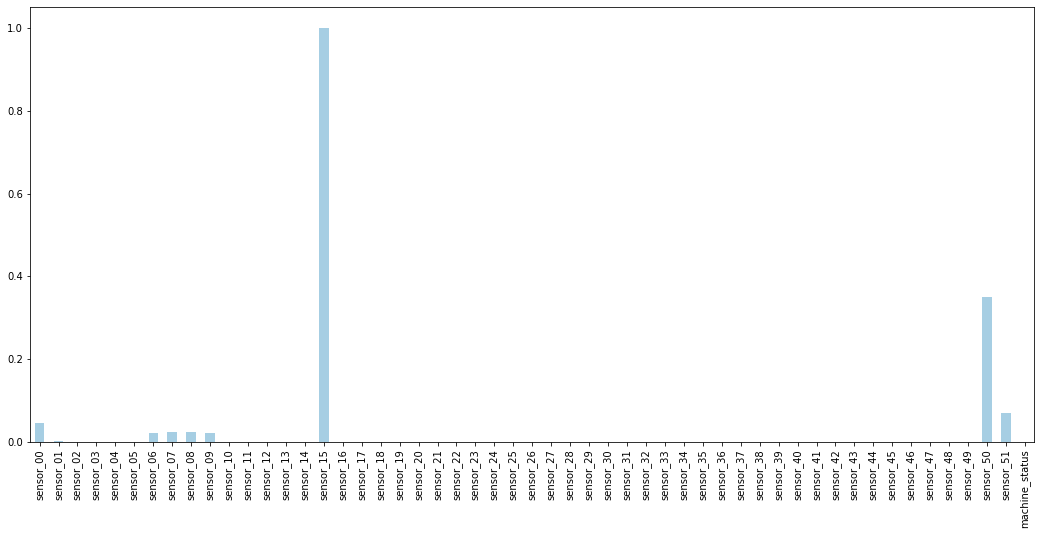

In [ ]:
# data preprocessing

# change data type (timestamp to datetime / for sensor to numeric)
for var_index in [item for item in df.columns if 'sensor_' in item]:
  df[var_index] = pd.to_numeric(df[var_index], errors = 'coerce')

del df['timestamp']

# find Null
(df.isnull().sum()/len(df)).plot.bar(figsize=(18, 8), colormap='Paired')


In [ ]:
# since sensor 15 is all null, sensor 50 is 50% null, delete
# other sensors with null, use previous time's data for null

# delete duplicates
df = df.drop_duplicates()

# delete sensor 15, 50
del df['sensor_15']
del df['sensor_50']

# fill null for previous data
df = df.fillna(method = 'ffill')
df


,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_51,machine_status
0,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,15.05353,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,201.3889,NORMAL
2,2.444734,47.35243,53.211800,46.397570,638.888900,73.54598,13.32465,16.03733,15.61777,15.01013,...,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,203.7037,NORMAL
3,2.460474,47.09201,53.168400,46.397568,628.125000,76.98898,13.31742,16.24711,15.69734,15.08247,...,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,203.1250,NORMAL
4,2.445718,47.13541,53.211800,46.397568,636.458300,76.58897,13.35359,16.21094,15.69734,15.08247,...,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,201.3889,NORMAL
5,2.453588,47.09201,53.168400,46.397568,637.615700,78.18568,13.41146,16.16753,15.89265,15.16204,...,31.250000,42.70833,38.773150,63.65741,51.79398,38.773150,164.6412,66.55093,201.6782,NORMAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220315,2.407350,47.69965,50.520830,43.142361,634.722229,64.59095,15.11863,16.65220,15.65393,15.16204,...,30.208330,38.28125,68.287030,52.37268,48.32176,41.087960,212.3843,153.64580,231.1921,NORMAL
220316,2.400463,47.69965,50.564240,43.142361,630.902771,65.83363,15.15480,16.70284,15.65393,15.11863,...,29.947920,38.28125,66.840280,50.63657,48.03241,40.798610,213.8310,156.25000,231.1921,NORMAL
220317,2.396528,47.69965,50.520830,43.142361,625.925903,67.29445,15.08970,16.70284,15.69734,15.11863,...,30.208330,39.06250,65.393520,48.90046,48.03241,40.798610,217.3032,155.38190,232.0602,NORMAL
220318,2.406366,47.69965,50.520832,43.142361,635.648100,65.09175,15.11863,16.56539,15.74074,15.11863,...,30.208332,40.62500,64.236110,47.74306,48.32176,40.509258,222.5116,153.93520,234.0856,NORMAL


In [ ]:
check_for_nan = df.isnull().values.any()
print (check_for_nan)

False


In [ ]:
Status = { "NORMAL": 1, "BROKEN": 0, "RECOVERING":0}
state = df["machine_status"].replace(Status)
df['machine_status']=state

df['machine_status']


0         1
2         1
3         1
4         1
5         1
         ..
220315    1
220316    1
220317    1
220318    1
220319    1
Name: machine_status, Length: 217444, dtype: int64

In [ ]:
# x, y
input_x = df.drop('machine_status', axis=1).values
input_y = df['machine_status'].values

n_features = input_x.shape[1]

In [ ]:
def temporalize(X, y, timesteps):
	output_X = []
	output_y = []
	for i in range(len(X) - timesteps - 1):
		t = []
		for j in range(1, timesteps + 1):
			# Gather the past records upto the lookback period
			t.append(X[[(i + j + 1)], :])
		output_X.append(t)
		output_y.append(y[i + timesteps + 1])
	return np.squeeze(np.array(output_X)), np.array(output_y)

In [ ]:
timesteps = 5 # 5min timestep 
# Temporalize
x, y = temporalize(input_x, input_y, timesteps)
print(x.shape) 

(217438, 5, 50)


In [ ]:
# Split into train, valid, and test 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2)

print(len(x_train))  
print(len(x_valid))  
print(len(x_test))   

139160
34790
43488


In [ ]:
# For training the autoencoder, split 0 / 1
# training only by normal data
x_train_y0 = x_train[y_train == 0]
x_train_y1 = x_train[y_train == 1]

x_valid_y0 = x_valid[y_valid == 0]
x_valid_y1 = x_valid[y_valid == 1]
print(x_train_y0.shape)

(9164, 5, 50)


In [ ]:
# LSTM은 3D data, Scaler는 2D data
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

In [ ]:
# 데이터가 편향되는 것을 막기 위해 standardize
scaler = StandardScaler().fit(flatten(x_train_y1))

x_train_y1_scaled = scale(x_train_y1, scaler)
x_valid_scaled = scale(x_valid, scaler)
x_valid_y1_scaled = scale(x_valid_y1, scaler)
x_test_scaled = scale(x_test, scaler)

[2] Model
- LSTM autoencoder
- sequence data를 효과적으로 학습

In [ ]:
# build model
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()
        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = (
            embedding_dim, 2 * embedding_dim
        )
        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.rnn2 = nn.LSTM(
          input_size=self.hidden_dim,
          hidden_size=embedding_dim,
          num_layers=1,
          batch_first=True
        )
    def forward(self, x):
        x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)
        return  x[:,-1,:]

In [ ]:
class TimeDistributed(nn.Module):
    def __init__(self, module, batch_first=False):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):
        if len(x.size()) <= 2:
            return self.module(x)
        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)
        y = self.module(x_reshape)
        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)
        return y

In [ ]:
class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()
        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features
        self.rnn1 = nn.LSTM(
          input_size=input_dim,
          hidden_size=input_dim,
          num_layers=1,
          batch_first=True
        )
        self.rnn2 = nn.LSTM(
          input_size=input_dim,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.output_layer = torch.nn.Linear(self.hidden_dim, n_features)
        self.timedist = TimeDistributed(self.output_layer)
        
    def forward(self, x):
        x=x.reshape(-1,1,self.input_dim).repeat(1,self.seq_len,1)       
        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        return self.timedist(x)

In [ ]:
class LSTM_ae(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(LSTM_ae, self).__init__()
        self.encoder = Encoder(seq_len, n_features, embedding_dim)#.to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features)#.to(device)
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
model = LSTM_ae(timesteps, n_features, 128)
model = model.to(device)

In [ ]:
class AutoencoderDataset(Dataset): 
    def __init__(self,x):
        self.x = x
    def __len__(self): 
        return len(self.x)
    def __getitem__(self, idx): 
        x = torch.FloatTensor(self.x[idx,:,:])
        return x

[3] Train

In [ ]:
def train_model(model, train_dataset, val_dataset, n_epochs,batch_size):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    # L1 loss : LAD(Least Absolute Deciations), 
    # the absolute difference between a prediction and the actual value, calculated for each example in a dataset
    criterion = nn.L1Loss(reduction='sum').to(device)
    history = dict(train=[], val=[])
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
    print("start!")
    train_dataset_ae = AutoencoderDataset(train_dataset)
    tr_dataloader = DataLoader(train_dataset_ae, batch_size=batch_size, 
                               shuffle=False,num_workers=8)
    val_dataset_ae = AutoencoderDataset(val_dataset)
    va_dataloader = DataLoader(val_dataset_ae, batch_size=len(val_dataset),
                               shuffle=False,num_workers=8)
    for epoch in range(1, n_epochs + 1):
        model = model.train()
        train_losses = []
        for batch_idx, batch_x in enumerate(tr_dataloader):
            optimizer.zero_grad()
            batch_x_tensor = batch_x.to(device)
            seq_pred = model(batch_x_tensor)
            loss = criterion(seq_pred, batch_x_tensor)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        val_losses = []
        model = model.eval()
        with torch.no_grad():
            va_x  =next(va_dataloader.__iter__())
            va_x_tensor = va_x.to(device)
            seq_pred = model(va_x_tensor)
            loss = criterion(seq_pred, va_x_tensor)
            val_losses.append(loss.item())
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        history['train'].append(train_loss)
        history['val'].append(val_loss)
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
    model.load_state_dict(best_model_wts)
    return model.eval(), history

In [ ]:
model, history = train_model(model, x_train_y1_scaled , x_train_y1_scaled , 
                             n_epochs = 200, batch_size=50)

start!


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1: train loss 2029.1754118699293 val loss 2955733.75
Epoch 2: train loss 995.5709823608398 val loss 2292935.25
Epoch 3: train loss 832.6947329477164 val loss 2052533.375
Epoch 4: train loss 761.2287459388147 val loss 1900890.25
Epoch 5: train loss 726.1264884127104 val loss 1841198.5
Epoch 6: train loss 695.6290033663237 val loss 1750637.75
Epoch 7: train loss 665.4485605093149 val loss 1694789.5
Epoch 8: train loss 632.1542553710938 val loss 1617160.5
Epoch 9: train loss 599.044689072829 val loss 1526384.875
Epoch 10: train loss 577.7995986703726 val loss 1479250.875
Epoch 11: train loss 560.8941808964656 val loss 1451192.25
Epoch 12: train loss 546.600923990103 val loss 1406583.0
Epoch 13: train loss 537.0457612844614 val loss 1381779.0
Epoch 14: train loss 525.6595156977727 val loss 1351949.5
Epoch 15: train loss 514.8408768169696 val loss 1328469.5
Epoch 16: train loss 504.53394017146184 val loss 1309805.25
Epoch 17: train loss 494.18340837918794 val loss 1274842.5
Epoch 18: 

In [ ]:
plt.plot(range(len(history["val"])), history["val"], label = 'validation loss' ) 
plt.plot(range(len(history["train"])), history["train"], label = 'train loss' ) 
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss')
plt.legend()

plt.show()

In [ ]:
# demonstrate reconstruction
x_predict = LSTM_ae.predict(x_test_scaled, verbose=0)
print('---Predicted---')
print(np.round(x_predict,3))
print('---Actual---')
print(np.round(x_test_scaled, 3))